In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/LandslideDetection/data'


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_images_path = os.path.join(data_dir, "train/images/")
train_masks_path = os.path.join(data_dir, "train/masks/")

In [ ]:
image_files = sorted(os.listdir(train_images_path))
mask_files = sorted(os.listdir(train_masks_path))

In [ ]:
# Read one image and its corresponding mask
image_path = os.path.join(train_images_path, image_files[0])
mask_path = os.path.join(train_masks_path, mask_files[0])


In [ ]:
# Load using OpenCV (or PIL)
image = cv2.imread(image_path)  # Reads as BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

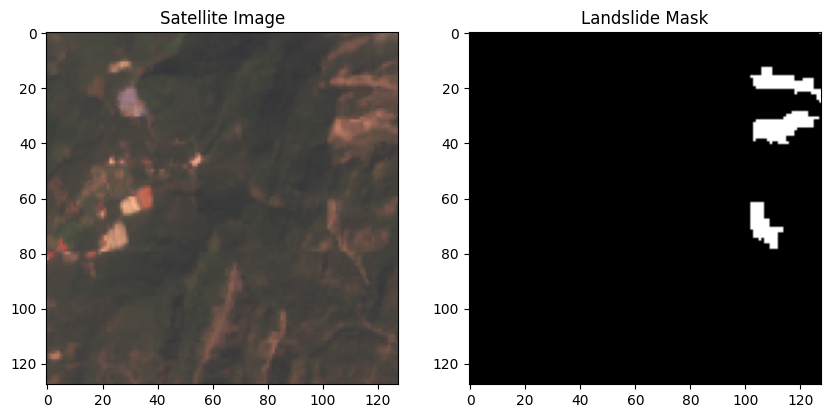

In [ ]:
# Show the image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Satellite Image")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Landslide Mask")
plt.show()

In [ ]:
import os
import cv2
import numpy as np

# Define paths
data_dir = '/content/drive/MyDrive/LandslideDetection/data'
train_images_path = os.path.join(data_dir, "train/images/")
train_masks_path = os.path.join(data_dir, "train/masks/")

# Get sorted list of image and mask files
image_files = sorted(os.listdir(train_images_path))
mask_files = sorted(os.listdir(train_masks_path))

# Initialize arrays for storing images and masks
images = []
masks = []

# Loop through image and mask files to load, resize, and append
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(train_images_path, img_file)
    mask_path = os.path.join(train_masks_path, mask_file)

    # Read image and mask
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if image and mask are loaded properly
    if img is None:
        print(f"Error loading image: {img_path}")
        continue
    if mask is None:
        print(f"Error loading mask: {mask_path}")
        continue

    # Resize image and mask to 256x256
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    # Normalize image
    img = img / 255.0  # Scale to range 0-1

    # Normalize mask and convert to binary (0 or 1)
    mask = mask / 255.0
    mask = np.where(mask > 0.5, 1, 0)  # Ensure binary values (0 or 1)

    # Add the image and mask to their respective arrays
    images.append(img)
    masks.append(mask)

# Convert lists to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.uint8)

# Check shapes
print("Images shape:", images.shape)  # Should be (204, 256, 256, 3)
print("Masks shape:", masks.shape)    # Should be (204, 256, 256, 1)


Images shape: (1385, 256, 256, 3)
Masks shape: (1385, 256, 256)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `images` and `masks` are lists or arrays of processed images and masks
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# Add an extra channel to y_train and y_test
y_train = np.expand_dims(y_train, axis=-1)  # Shape becomes (n_train, 256, 256, 1)
y_val = np.expand_dims(y_val, axis=-1)    # Shape becomes (n_test, 256, 256, 1)

# Print the new shapes
print(f"New y_train shape: {y_train.shape}")
print(f"New y_val shape: {y_val.shape}")

New y_train shape: (1108, 256, 256, 1)
New y_val shape: (277, 256, 256, 1)


In [ ]:
print("X_train shape:", X_train.shape)  # Should be (204, 256, 256, 3)
print("y_train shape:", y_train.shape)  # Should be (204, 256, 256, 1)

X_train shape: (1108, 256, 256, 3)
y_train shape: (1108, 256, 256, 1)


In [ ]:
import tensorflow as tf

def data_generator(X, y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X))  # Shuffle the dataset
    dataset = dataset.batch(batch_size)  # Batch the dataset
    return dataset

# Create datasets for training and validation
batch_size = 8  # You can adjust the batch size
train_dataset = data_generator(X_train, y_train, batch_size)
val_dataset = data_generator(X_val, y_val, batch_size)

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder (downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (upsampling)
    u1 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c4)
    u1 = layers.concatenate([u1, c3], axis=-1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2], axis=-1)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1], axis=-1)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = tf.keras.Model(inputs, outputs)

    return model

# Now you can create the model instance
model = unet_model(input_size=(256, 256, 3))
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype='float32')  # Ensure same dtype
    y_pred = K.cast(y_pred, dtype='float32')

    y_pred = K.round(y_pred)  # Convert probabilities to binary (0 or 1)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return 1 - (intersection + smooth) / (union + smooth)  # IoU loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

# Compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
optimizer = Adam(learning_rate=0.0001)  # Reduce from default 0.001 to 0.0001

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=optimizer,  loss=iou_loss, metrics=["accuracy", iou_metric])

# Summary of the model architecture
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 128, 128, 64)   │              0 │ conv2d_31[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 64, 64, 128)    │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 32, 32, 256)    │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 64, 64, 256)    │      1,179,904 │ conv2d_37[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 64, 64, 512)    │              0 │ conv2d_transpose_6[0]… │
│ (Concatenate)             │                        │                │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 64, 64, 256)    │      1,179,904 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7   

 Total params: 8,557,505 (32.64 MB)

 Trainable params: 8,557,505 (32.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 73s 461ms/step - accuracy: 0.9561 - loss: 0.3744 - val_accuracy: 0.9570 - val_loss: 0.1077
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 72s 428ms/step - accuracy: 0.9541 - loss: 0.1073 - val_accuracy: 0.9612 - val_loss: 0.0950
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 428ms/step - accuracy: 0.9625 - loss: 0.0930 - val_accuracy: 0.9640 - val_loss: 0.0911
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 424ms/step - accuracy: 0.9593 - loss: 0.0953 - val_accuracy: 0.9628 - val_loss: 0.0898
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.9624 - loss: 0.0912 - val_accuracy: 0.9636 - val_loss: 0.0855
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 420ms/step - accuracy: 0.9616 - loss: 0.0911 - val_accuracy: 0.9636 - val_loss: 0.0869
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 420ms/step - accuracy: 0.9618 - loss: 0.0900 - val_accuracy: 0.9651 - val_loss: 0.0831
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 420ms/step - accuracy: 0.9639 - loss: 0

In [ ]:
def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Convert to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Convert to float32

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

In [ ]:
loss, iou_score = model.evaluate(X_val, y_val, batch_size=8)  # Adjust batch size if needed
print(f"Test Loss: {loss:.4f}")
print(f"Test IoU: {iou_score:.4f}")  # IoU score

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - iou: 0.3286 - loss: 0.0725
Test Loss: 0.0731
Test IoU: 0.3138


In [ ]:
new_image = tf.io.read_file('/content/drive/MyDrive/LandslideDetection/data/test/images/image_366.png')

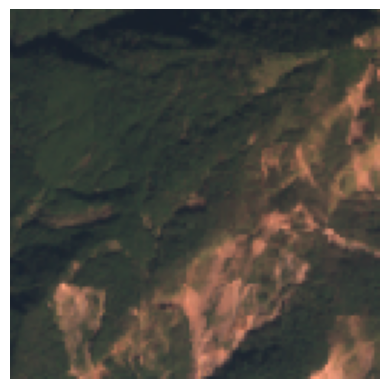

In [ ]:
#display selected test image
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the image
new_image_path = '/content/drive/MyDrive/LandslideDetection/data/test/images/image_366.png'
new_image = tf.io.read_file(new_image_path)

# Decode the image to a tensor
new_image = tf.image.decode_png(new_image, channels=3)  # Use channels=3 for RGB images

# Convert the tensor to a numpy array
new_image = new_image.numpy()

# Display the image
plt.imshow(new_image)
plt.axis('off')  # Optional: To remove the axis
plt.show()

In [ ]:
# Load the image
new_image_path = '/content/drive/MyDrive/LandslideDetection/data/test/images/image_1319.png'
new_image = tf.io.read_file(new_image_path)

# Assuming the image is a PNG based on its extension
new_image = tf.image.decode_png(new_image, channels=3)

new_image = tf.image.convert_image_dtype(new_image, dtype=tf.float32)
# Resize to match input shape
new_image = tf.image.resize(new_image, (256, 256))

# Add batch dimension
new_image = tf.expand_dims(new_image, axis=0)


In [ ]:
prediction = model.predict(new_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [ ]:
prediction = model.predict(new_image)[0, :, :, 0]  # Remove batch and channel
binary_mask = (prediction > 0.5).astype(np.uint8)  # Apply threshold

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [ ]:
#prediction = tf.squeeze(prediction)
prediction = np.reshape(prediction, (256, 256))
prediction = tf.round(prediction)

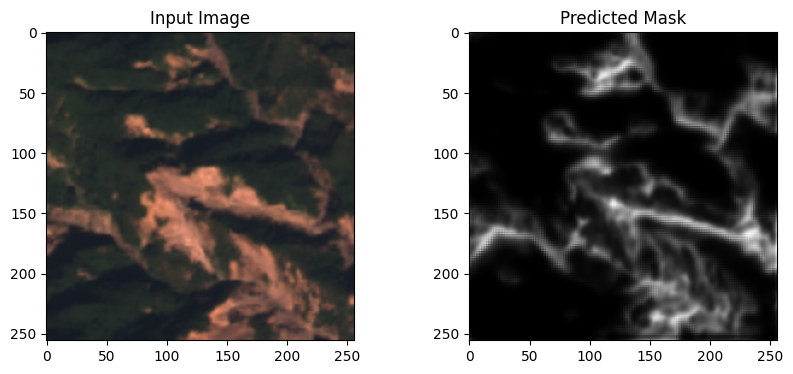

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(tf.squeeze(new_image[0]))
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(prediction), cmap='gray')
plt.title("Predicted Mask")

plt.show()

In [ ]:
# Define the path where you want to save the model
save_path = "/content/drive/MyDrive/LandslideDetection/UNet_model.h5"

# Save the entire model
model.save(save_path)
print(f"Model saved at: {save_path}")

Model saved at: /content/drive/MyDrive/LandslideDetection/UNet_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step

Confusion Matrix:
 [[12199733   238647]
 [  207673   395611]]

Accuracy: 0.9657773731940955
Precision: 0.623738289465801
Recall: 0.6557624601348618
F1 Score: 0.6393496139928988


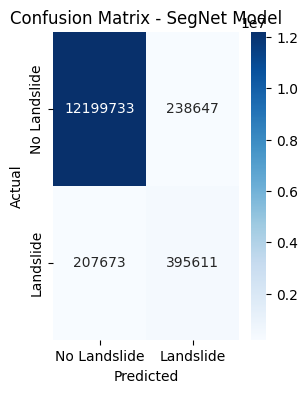


Total Landslide Pixels (Ground Truth): 603284
Total Landslide Pixels (Predicted): 634258


In [ ]:
import numpy as np
import cv2
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ✅ Load UNet Model
model = tf.keras.models.load_model("/content/drive/MyDrive/LandslideDetection/UNet_model.h5")

# ✅ Define paths
test_images_path = "/content/drive/MyDrive/LandslideDetection/data/test/images/"
test_masks_path = "/content/drive/MyDrive/LandslideDetection/data/test/masks/"

# ✅ Load and preprocess images
image_files = sorted(os.listdir(test_images_path))
mask_files = sorted(os.listdir(test_masks_path))

test_images = []
test_masks = []

for img_file, mask_file in zip(image_files, mask_files):
    # Load image and mask
    img = cv2.imread(os.path.join(test_images_path, img_file))
    mask = cv2.imread(os.path.join(test_masks_path, mask_file), cv2.IMREAD_GRAYSCALE)

    # Resize and normalize
    img = cv2.resize(img, (256, 256)) / 255.0
    mask = cv2.resize(mask, (256, 256))

    # Convert mask to binary (0 or 1)
    mask = np.where(mask > 127, 1, 0).astype(np.uint8)

    test_images.append(img)
    test_masks.append(mask)

test_images = np.array(test_images, dtype=np.float32)  # (N, 256, 256, 3)
test_masks = np.array(test_masks, dtype=np.uint8)  # (N, 256, 256)

# ✅ Get model predictions
pred_masks = model.predict(test_images)  # Output: (N, 256, 256, 1)
pred_masks = np.where(pred_masks > 0.3, 1, 0).astype(np.uint8)  # Binarize predictions

# ✅ Flatten labels and predictions
y_true = test_masks.flatten()
y_pred = pred_masks.flatten()

# ✅ Compute metrics
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)

# ✅ Print results
print("\nConfusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(3, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Landslide', 'Landslide'], yticklabels=['No Landslide', 'Landslide'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SegNet Model")
plt.show()

# ✅ Visualize some predictions
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# for i in range(3):
#     axes[i, 0].imshow(test_images[i])
#     axes[i, 0].set_title("Input Image")
#     axes[i, 0].axis("off")

#     axes[i, 1].imshow(pred_masks[i], cmap='plasma')
#     axes[i, 1].set_title("Raw Prediction")
#     axes[i, 1].axis("off")

#     axes[i, 2].imshow(test_masks[i], cmap='gray')
#     axes[i, 2].set_title("Ground Truth Mask")
#     axes[i, 2].axis("off")

# plt.show()

# ✅ Additional Debugging (Check Class Balance)
print(f"\nTotal Landslide Pixels (Ground Truth): {np.sum(y_true)}")
print(f"Total Landslide Pixels (Predicted): {np.sum(y_pred)}")